# Basic analysis of PES spectra

In [1]:
import matplotlib.pyplot as plt
import toolbox_scs as tb

First, we load the raw traces of PES (W and E channels), the pressure and the XGM pulse energy. In this run, 100 pulses per train were recorded.

In [2]:
proposal = 2927
runNB = 100

fields = ['PES_W_raw', 'PES_E_raw', 'PES_pressure', 'XTD10_SA3']
run, ds = tb.load(proposal, runNB, fields)
ds

<xarray.Dataset>
Dimensions:            (PESsampleId: 600000, pulse_slot: 2700, sa3_pId: 100, trainId: 4044)
Coordinates:
  * trainId            (trainId) uint64 1044495172 1044495174 ... 1044501582
  * sa3_pId            (sa3_pId) int64 1032 1036 1040 1044 ... 1420 1424 1428
Dimensions without coordinates: PESsampleId, pulse_slot
Data variables:
    bunchPatternTable  (trainId, pulse_slot) uint32 2113321 0 2097193 ... 0 0 0
    PES_W_raw          (trainId, PESsampleId) int16 1 5 -1 2 3 3 ... 4 -1 4 1 4
    PES_E_raw          (trainId, PESsampleId) int16 -5 -8 -5 -5 ... -5 -3 -7 -3
    PES_pressure       (trainId) float32 6.28733e-07 ... 6.7894194e-07
    XTD10_SA3          (trainId, sa3_pId) float64 2.661e+03 ... 2.11e+03
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202121/p002927/raw/r0100

We can now plot the raw trace for one train:

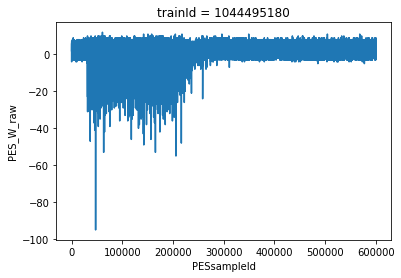

In [3]:
ds.PES_W_raw.isel(trainId=5).plot()

## PES parameters

In [4]:
params = tb.get_pes_params(run)
params

{'gas': 'N2', 'ret_voltage': 0.0}

## Extracting PES spectra from raw traces

The function `get_pes_tof()` selects the sample intervals containing the spectra, subtracts a baseline, aligns the spectra to the SASE 3 pulse Id and assigns time-of-flight coordinates, based on the digitizer sampling rate. The default parameters `start` and `width` are usually correct but they may need to be adjusted depending on the signal.

In [5]:
pes = tb.get_pes_tof(run, merge_with=ds)
# this is to make sure that the train Ids are well sorted
pes = pes.sortby(pes.trainId)
pes

<xarray.Dataset>
Dimensions:            (pulse_slot: 2700, sa3_pId: 100, time_ns: 300, trainId: 4044)
Coordinates:
  * trainId            (trainId) uint64 1044495172 1044495174 ... 1044501582
  * sa3_pId            (sa3_pId) int64 1032 1036 1040 1044 ... 1420 1424 1428
  * time_ns            (time_ns) float64 0.0 0.5 1.0 1.5 ... 148.5 149.0 149.5
Dimensions without coordinates: pulse_slot
Data variables:
    bunchPatternTable  (trainId, pulse_slot) uint32 2113321 0 2097193 ... 0 0 0
    PES_pressure       (trainId) float32 6.28733e-07 ... 6.7894194e-07
    XTD10_SA3          (trainId, sa3_pId) float64 2.661e+03 ... 2.11e+03
    PES_E_tof          (sa3_pId, trainId, time_ns) float64 -3.6 -0.6 ... 0.4125
    PES_W_tof          (sa3_pId, trainId, time_ns) float64 -1.337 ... 0.0375
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202121/p002927/raw/r0100

In the dataset above, `PES_W_raw` and `PES_E_raw` are replaced by `PES_W_tof` and `PES_E_tof`, which have dimensions `trainId`, `sa3_pId`, `time_ns`. We can plot for instance the mean spectrum over all pulses for each train:

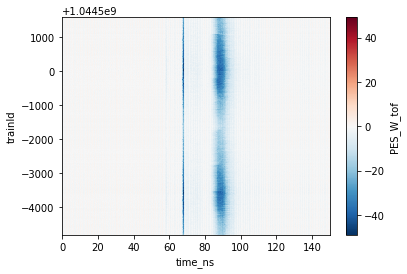

In [6]:
plt.figure()
pes.PES_W_tof.mean(dim='sa3_pId').plot()

## Signal normalization

The intensity is slowly varying as a function of train Id. The main reason is the oscillating pressure in the PES, but it can also be related to pulse energy variations. We can plot the pressure and pulse energy as a function of train:

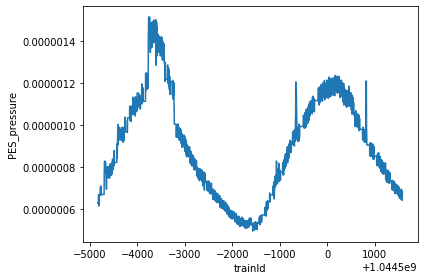

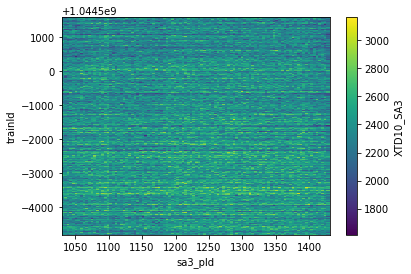

In [7]:
plt.figure()
pes.PES_pressure.plot()
plt.tight_layout()

plt.figure()
pes.XTD10_SA3.plot()

Normalization can be performed as follows:

In [8]:
pes['PES_W_norm'] = pes['PES_W_tof'] / (pes['PES_pressure'] * pes['XTD10_SA3'])
pes['PES_E_norm'] = pes['PES_E_tof'] / (pes['PES_pressure'] * pes['XTD10_SA3'])

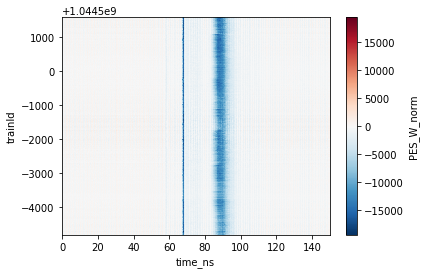

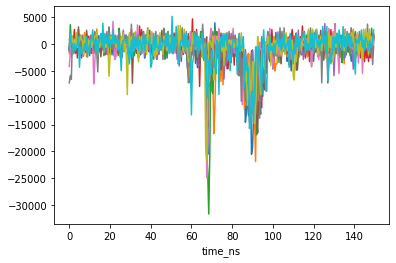

In [9]:
plt.figure()
pes.PES_W_norm.mean(dim='sa3_pId').plot()

# first 10 spectra of first train
plt.figure()
plt.plot(pes.time_ns, pes.PES_W_norm.isel(trainId=0, sa3_pId=slice(10)).T)
plt.xlabel('time_ns');